In [2]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle

In [2]:
with open(f"upstream_model_18_0_2500.pkl","rb")as f:
    upstream_model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'upstream_model_18_0_2500.pkl'

In [3]:
with open(f"error_params_predicts_execute_18bits_train_0_2500_bias.pkl","rb")as f:
# with open(f"error_params_predicts_execute_18bits_train_0_2500.pkl","rb")as f:
    downstream_model, predicts, reals, durations = pickle.load(f)
error_params = downstream_model.error_params
print(error_params)
error_params = downstream_model.error_params['gate_params']

FileNotFoundError: [Errno 2] No such file or directory: 'error_params_predicts_execute_18bits_train_0_2500_bias.pkl'

In [4]:
# with open(f"error_params_predicts_execute_18bits_train_0_2500_bias.pkl","rb")as f:
# with open(f"error_params_predicts_execute_18bits_train_0_2500.pkl","rb")as f:
#     error_params, predicts, reals, durations = pickle.load(f)
# error_params = downstream_model.error_params

In [5]:
downstream_model.error_params

{'circuit_bias': Array([-74.10199], dtype=float32),
 'gate_params': Array([[5.5104822e-02, 7.0192432e-03, 1.3777038e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [6.6061602e+00, 7.6305266e-03, 1.0322740e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [5.1740998e-01, 7.6044691e-03, 2.4176327e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [1.5225390e+01, 4.2706898e+01, 2.4880020e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [9.3495053e-01, 1.7051668e+01, 2.6067852e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [3.9522758e+01, 3.1537554e+01, 5.0256915e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)}

In [6]:
# list(downstream_model.error_params['gate_params'])

In [7]:
# error_params = error_params['gate_params']

In [8]:
with open(f"execute_18bit/split_dataset_execute_18bits_train_0_2500.pkl","rb")as f:
    train_dataset, test_dataset = pickle.load(f)

In [9]:
reals = []
for idx, cir in enumerate(test_dataset):
    reals.append(cir['ground_truth_fidelity'])

In [10]:
len(reals)

1500

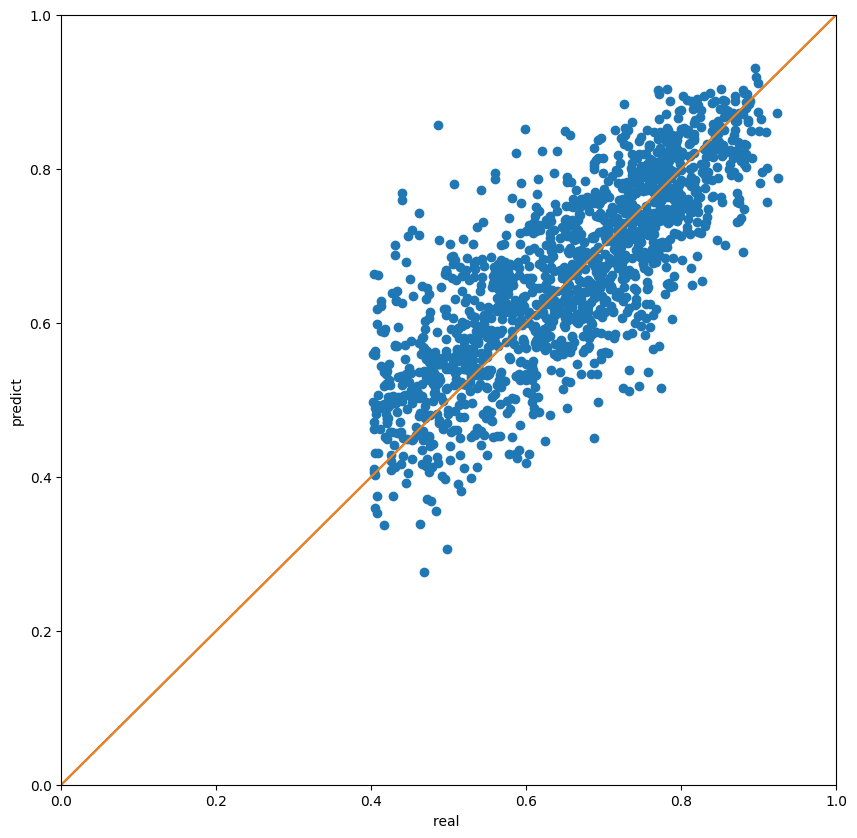

In [11]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, predicts)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('18qubit_predict_step1.png')

In [12]:
device_index2device = {}  # 两比特门与但单比特门映射为一维下标
for device in upstream_model.device2path_table.keys():
    device_index = list(
        upstream_model.device2path_table.keys()).index(device)
    device_index2device[device_index] = device

error_params_path_weight = {}  # 训练好的参数对应的path及其权重
error_params_path = {}
for idx, device_error_param in enumerate(error_params):
    device = device_index2device[idx]
    sort = np.argsort(device_error_param)
    sort = sort[::-1]
    device_error_params_path_weight = []
    device_error_params_path = []
    for i in sort:
        if int(i) in upstream_model.device2reverse_path_table[device].keys():
            path = upstream_model.device2reverse_path_table[device][int(i)]
            if isinstance(path, str):
                device_error_params_path_weight.append(
                    (path, float(device_error_param[i])))
                device_error_params_path.append(path)
    error_params_path_weight[device] = device_error_params_path_weight
    error_params_path[device] = device_error_params_path
    
error_params_path_weight

/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3485: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


{0: [('ry,0-parallel-cz,6,12', 57.87481689453125),
  ('rz,0-parallel-cz,6,12', 57.23011016845703),
  ('rx,0-former-cz,6,12', 54.446598052978516),
  ('rz,0-former-cz,6,12', 49.626434326171875),
  ('ry,0-former-cz,6,12', 33.99186706542969),
  ('ry,0-former-cz,0,6', 31.99451446533203),
  ('ry,0-former-cz,0,1', 30.438182830810547),
  ('rx,0-former-cz,0,6', 28.98582649230957),
  ('rx,0-parallel-cz,1,2', 25.642318725585938),
  ('rz,0-former-cz,0,1', 24.372465133666992),
  ('rz,0-parallel-cz,1,2', 24.106420516967773),
  ('rx,0-parallel-cz,6,7', 20.705629348754883),
  ('ry,0-former-cz,6,7', 19.767547607421875),
  ('ry,0', 19.005661010742188),
  ('rx,0-parallel-cz,6,12', 18.68248176574707),
  ('ry,0-former-cz,1,2', 16.94984245300293),
  ('rx,0-former-rx,0', 16.09337615966797),
  ('rz,0-former-rz,0', 15.705180168151855),
  ('rz,0-former-ry,0', 14.830892562866211),
  ('ry,0-former-rz,0', 14.830642700195312),
  ('rz,0', 11.346132278442383),
  ('ry,0-parallel-ry,6', 8.546550750732422),
  ('ry,0-for

In [ ]:
all_path_error =[]
for device in error_params_path_weight.items():
    error_params_path_weight

In [13]:
from openpyxl import Workbook
wb = Workbook()

for device, device_error_params_path_weight in error_params_path_weight.items():
    ws = wb.create_sheet(str(device))
    for row in device_error_params_path_weight:
        row = list(row)
        ws.append(row)

# Save the file
wb.save("execute_18bits_train_0_2500.xlsx")

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10, 10)) 
axes.bar(single_average_error.keys(),single_average_error.values())
axes.set_xticks(list(single_average_error.keys()))
axes.set_ylim(0.99,1)
fig.savefig('18_single.svg')

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20, 10))
axes.bar([i for i in range(len(couple_average_error.keys()))],couple_average_error.values())
axes.set_xlabel([key for key in couple_average_error.keys()])
axes.set_ylim(0.95,1)

In [3]:
test_dataset[10].keys()

dict_keys(['qiskit_circuit', 'num_qubits', 'divide_qubits', 'gate_paths', 'path_indexs', 'vecs', 'layer2gates', 'gates', 'gate2layer', 'gate_num', 'map', 'reverse_map', 'duration', 'state_count', 'ground_truth_fidelity', 'circuit_predict'])

In [75]:
# n_gates2n_two_gate2circuits = defaultdict(lambda : defaultdict(list))
# for circuit_info in test_dataset:
#     n_gates = len(circuit_info['gates'])
#     n_two_gates = len([gate for gate in  circuit_info['gates'] if len(gate['qubits']) == 2])
#     n_gates2n_two_gate2circuits[n_gates][n_two_gates].append(circuit_info)

# upstream_model: RandomwalkModel = downstream_model.upstream_model
# for n_gates_list in n_gates2n_two_gate2circuits.values():
#     for n_two_gate_list in n_gates_list.values():
#         if len(n_gates_list) <= 1:
#             continue
        
#         for i1, c1 in enumerate(n_gates_list):
#             p1 = circuit_predict
#             for c2 in n_gates_list[i1+1:]:
                
                
                
                
            
    


In [3]:
with open(f"execute_18bit/step1/error_params_predicts_execute_18bits_train_0_2500_step1.pkl","rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/tmp/ipykernel_442972/2737969270.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable( cmap=cmap))


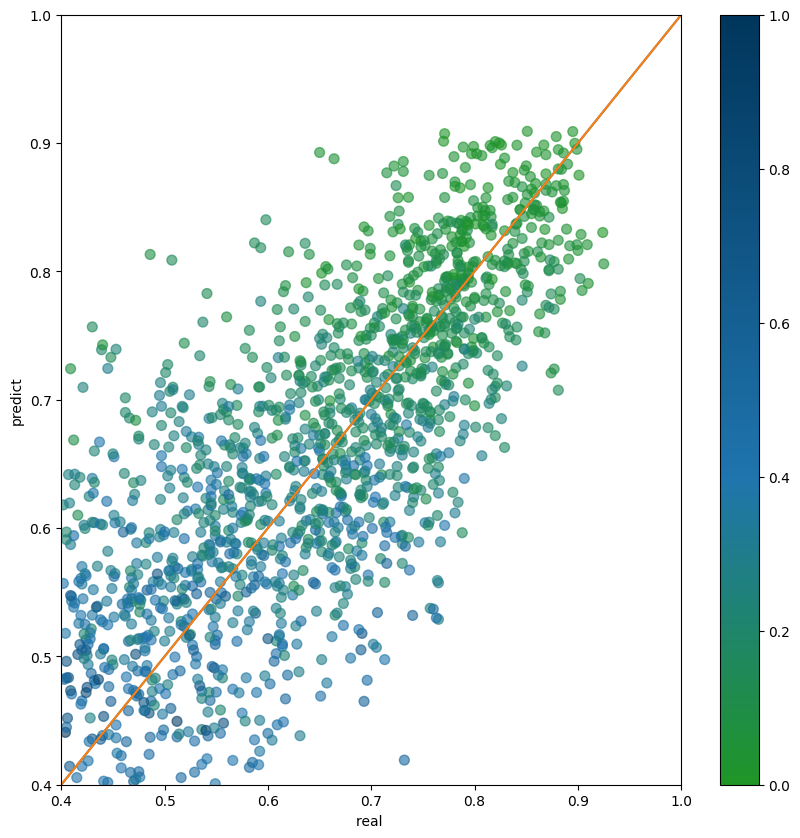

In [123]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#定义颜色
colors = [[31, 150, 39],  [31, 117, 175], [0, 54, 92], ]
'''xia <- shang'''
# colors.reverse()
colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0,  0.4, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step0/18_qubit_predict.svg')

/tmp/ipykernel_1124145/3633833890.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable( cmap=cmap))


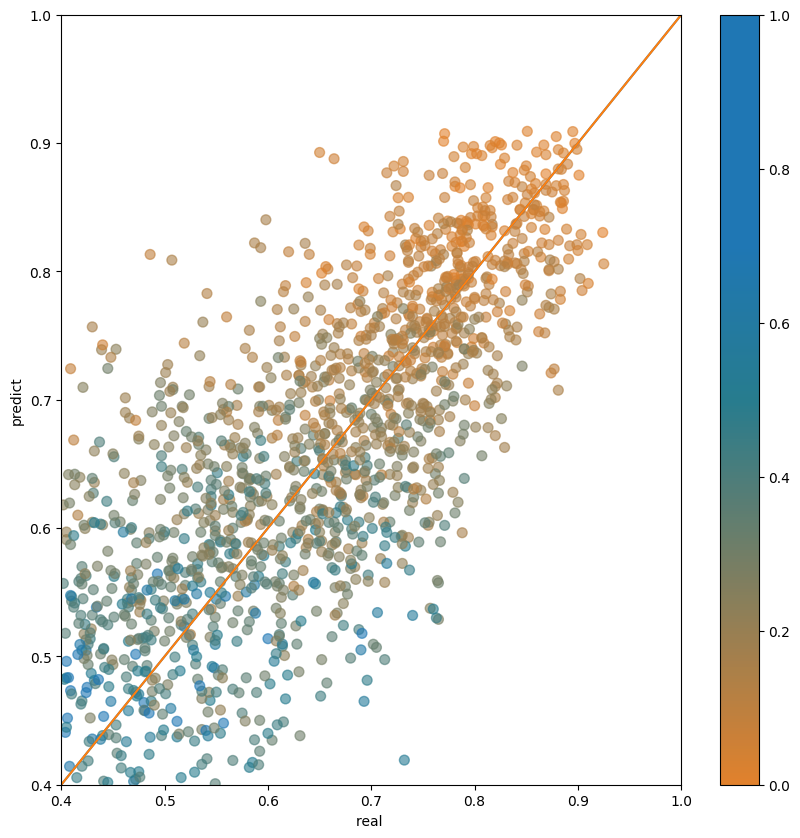

In [43]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#定义颜色
colors = ["#E1812C", "#277C8E", "#1F77B4", "#1F77B4"]
'''xia <- shang'''
# colors.reverse()
# colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0, .5, 0.7, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step0/18_qubit_predict.svg')

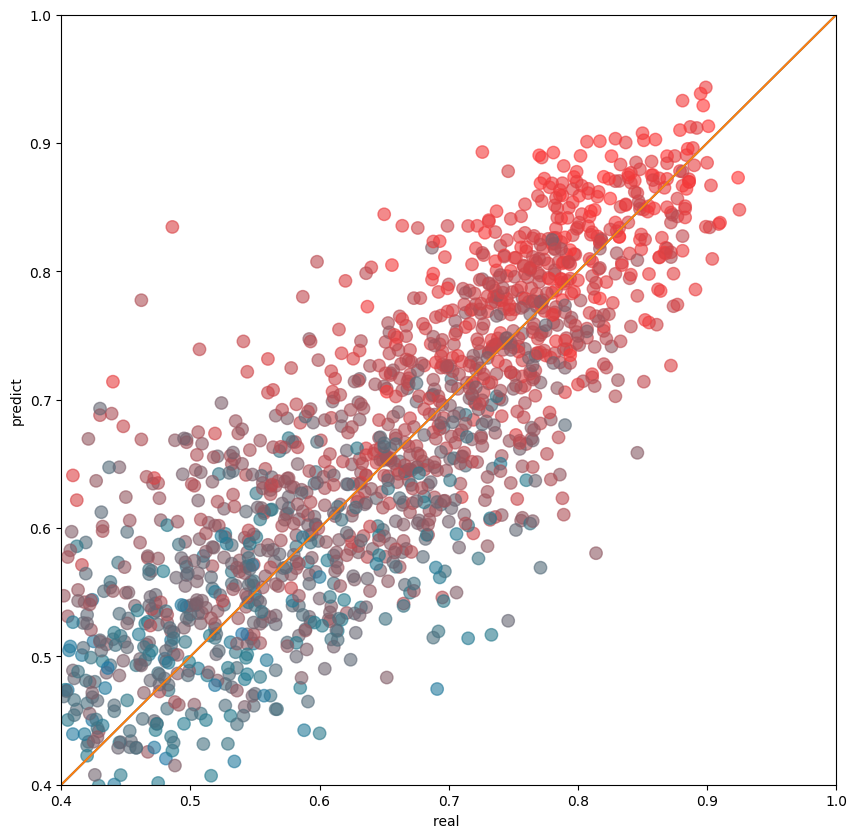

In [25]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#定义颜色
colors = ["#FF3636", '#277C8E' ,"#1F77B4"]
'''xia <- shang'''
# colors.reverse()
# colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0, .5, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=80 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
# fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step1/18_qubit_predict.svg')

(0.4719627290406931, 0.5058628631991604)

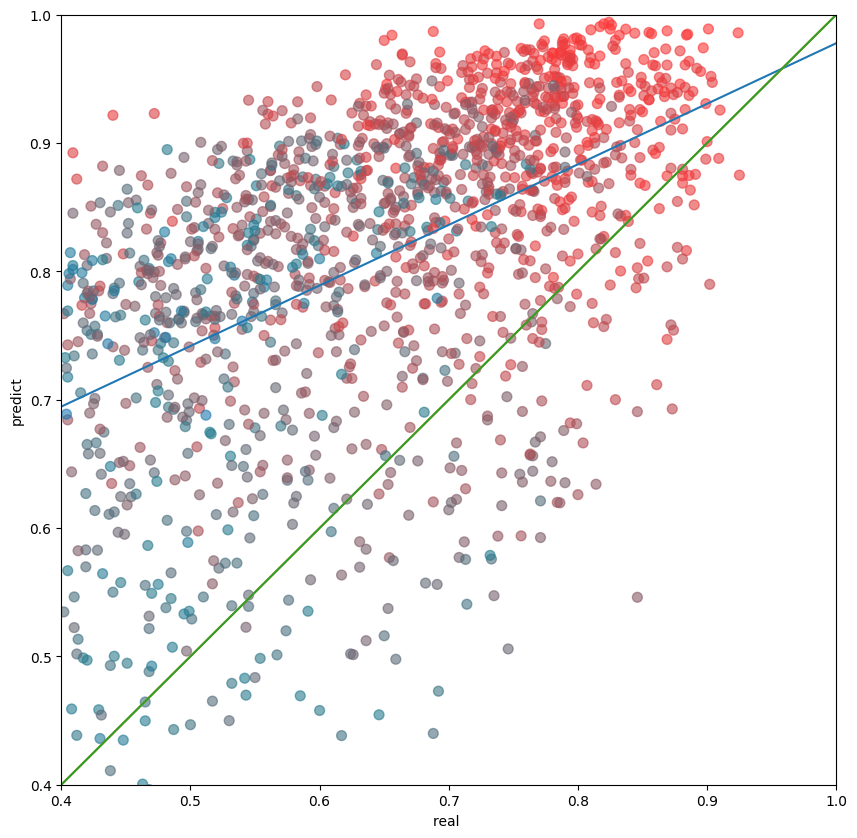

In [19]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

par = np.polyfit(reals, rbs, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
x1 = [0.4, 1.0]
y1 = [slope*xx + intercept  for xx in x1]
#定义颜色
colors = ["#FF3636", '#277C8E' ,"#1F77B4"]
'''xia <- shang'''
# colors.reverse()
# colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0, .5, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]
rbs = np.array(rbs)
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], rbs[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.plot(x1,y1)
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
# fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step1/18_qubit_rb.svg')
slope, intercept

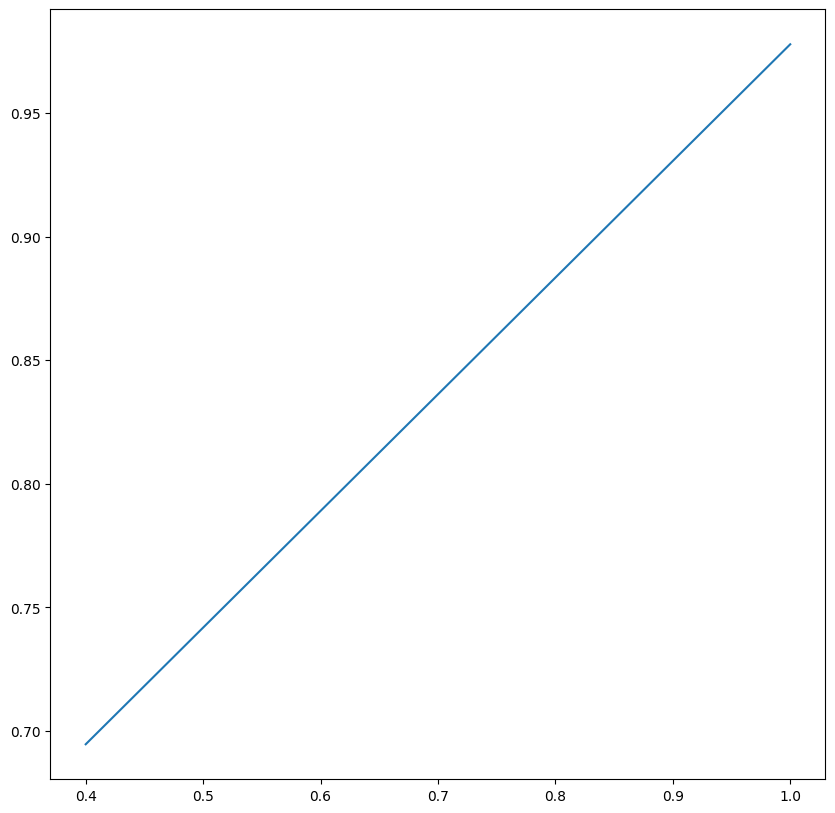

In [16]:


fig.show()

/tmp/ipykernel_1124145/3500186649.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable( cmap=cmap))


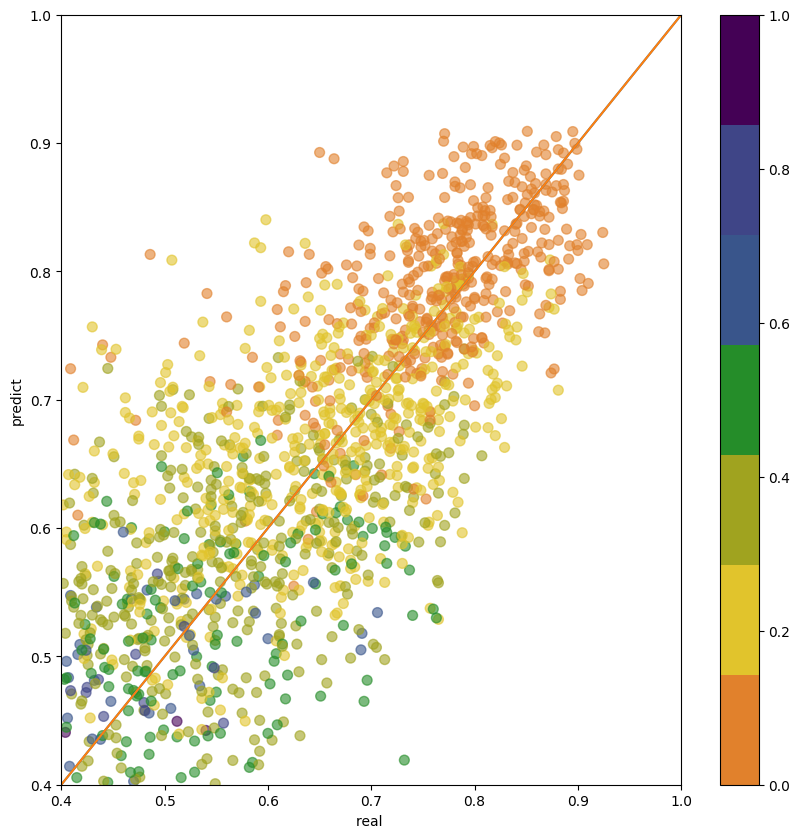

In [53]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import numpy as np

#定义颜色
# colors = ['#DCE218','#74D054','#1FA386',"#25818D", '#39558B', '#3F4587',"#440155"]
colors = ['#E1812C','#E1C42C','#A0A31F',"#258D29", '#39558B', '#3F4587',"#440155"]
'''xia <- shang'''
cmap = ListedColormap(colors)

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step0/18_qubit_predict.svg')

/tmp/ipykernel_1124145/2684531522.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable( cmap=cmap))


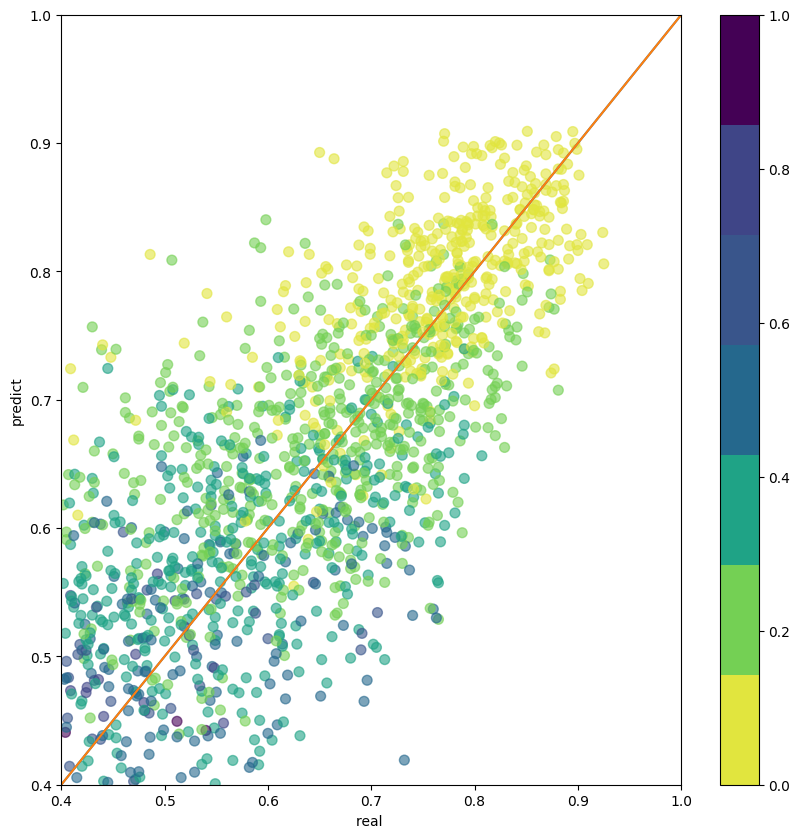

In [57]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import numpy as np

#定义颜色
colors = ['#E1E53E','#74D054','#1FA386',"#25688D", '#39558B', '#3F4587',"#440155"]
# colors = ['#E1812C','#E1C42C','#A0A31F',"#258D29", '#39558B', '#3F4587',"#440155"]
'''xia <- shang'''
cmap = ListedColormap(colors)

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step0/18_qubit_predict.svg')

In [21]:
from circuit.parser import get_couple_prop

props = [] 
for cir in test_dataset:
    prop = get_couple_prop(cir)
    # print(prop)
    cir['prop'] = prop
    props.append(prop)
    
props = np.array(props)
props

array([0.26666667, 0.23076923, 0.19047619, ..., 0.43333333, 0.2       ,
       0.25      ])

In [6]:
from upstream.randomwalk_model import extract_device
def get_xeb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error[device]
        else:
            device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [4]:
single_average_error = {0: 0.9994094148043156, # rb
 1: 0.9993508083886652,
 2: 0.9993513578387458,
 3: 0.9996978330672296,
 4: 0.9997258463524775,
 5: 0.9993898065578337,
 6: 0.9998335484697743,
 7: 0.9997460044815009,
 8: 0.9997219426985601,
 9: 0.9992924485427597,
 10: 0.9994018918682177,
 11: 0.9998410411794697,
 12: 0.9994231683912435,
 13: 0.9995938422219371,
 14: 0.9947661045069707,
 15: 0.9997576786354693,
 16: 0.9998387638441334,
 17: 0.9996691783504945}
couple_average_error = {(5,11): 0.993651602350742, # rb
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}

In [8]:
rbs = []
for cir in test_dataset:
    rbs.append(get_xeb_fidelity(cir))
(np.array(rbs)-np.array(reals)).mean(), (np.array(rbs)-np.array(reals)).std()


(0.1625175405281377, 0.12665931085859125)

TypeError: list indices must be integers or slices, not list

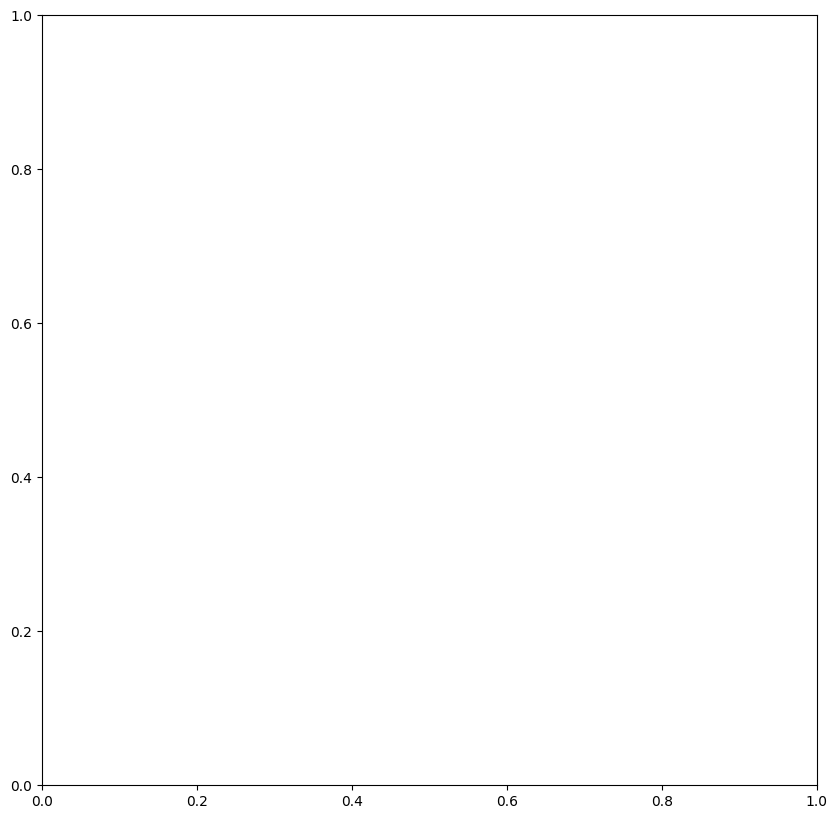

In [9]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#定义颜色
colors = [[31, 150, 39],  [31, 117, 175], [0, 54, 92], ]
'''xia <- shang'''
# colors.reverse()
colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0,  0.4, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], rbs[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit/step1/18_qubit_rb.svg')

In [20]:
single_average_error = {0: 0.9994, #xeb
 1: 0.99956,
 2: 0.99918,
 3: 0.99976,
 4: 0.9994,
 5: 0.99962,
 6: 0.99989,
 7: 0.99973,
 8: 0.99961,
 9: 0.99941,
 10: 0.99975,
 11: 0.99939,
 12: 0.99873,
 13: 0.9996,
 14: 0.99946,
 15: 0.99976,
 16: 0.99977,
 17: 0.99975}
couple_average_error = {(5, 11): 0.98602, # xeb
 (11, 17): 0.99561,
 (4, 5): 0.99482,
 (10, 11): 0.99529,
 (16, 17): 0.996,
 (4, 10): 0.9908,
 (10, 16): 0.99501,
 (3, 4): 0.99738,
 (9, 10): 0.99373,
 (15, 16): 0.9934499999999999,
 (3, 9): 0.99659,
 (9, 15): 0.99357,
 (2, 3): 0.99353,
 (8, 9): 0.98778,
 (14, 15): 0.9956,
 (2, 8): 0.98862,
 (8, 14): 0.99711,
 (1, 2): 0.99445,
 (7, 8): 0.97725,
 (13, 14): 0.99527,
 (1, 7): 0.99098,
 (7, 13): 0.99424,
 (0, 1): 0.99394,
 (6, 7): 0.99452,
 (12, 13): 0.99141,
 (0, 6): 0.99474,
 (6, 12): 0.99312}

In [21]:
xebs = []
for cir in test_dataset:
    xebs.append(get_xeb_fidelity(cir))
(np.array(xebs)-np.array(reals)).mean(), (np.array(xebs)-np.array(reals)).std()


(0.24375340971346696, 0.10118285944342431)

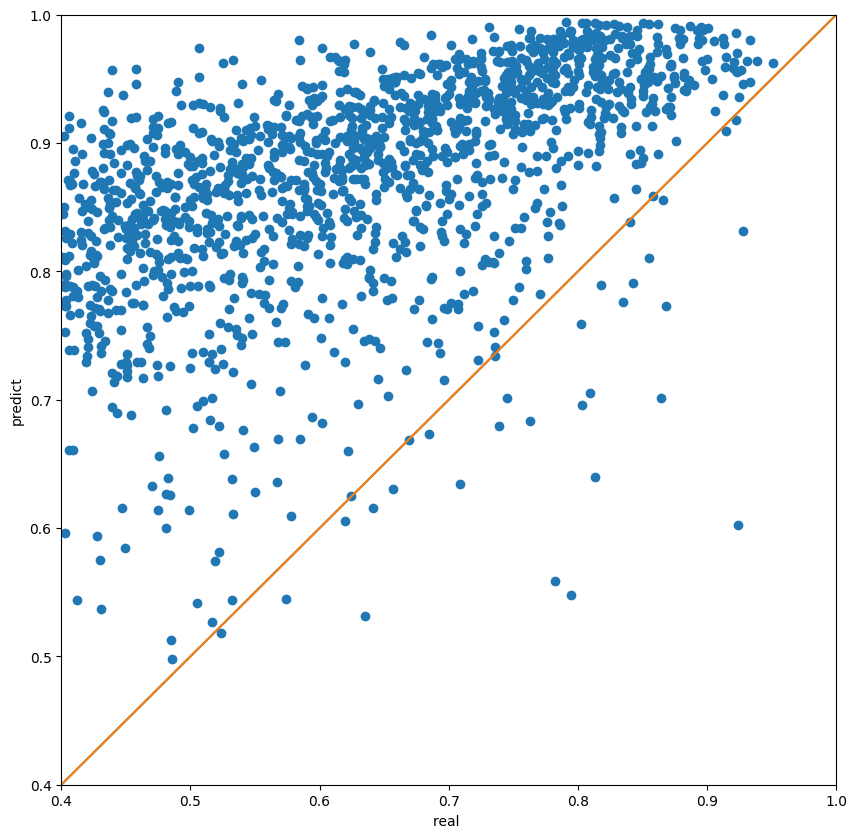

In [28]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, xebs)
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('execute_18bit/step1/18_qubit_xeb.svg')

In [23]:

predicts = np.array(predicts)
reals = np.array(reals)
durations = np.array(durations)
xebs = np.array(xebs)
rbs = np.array(rbs)

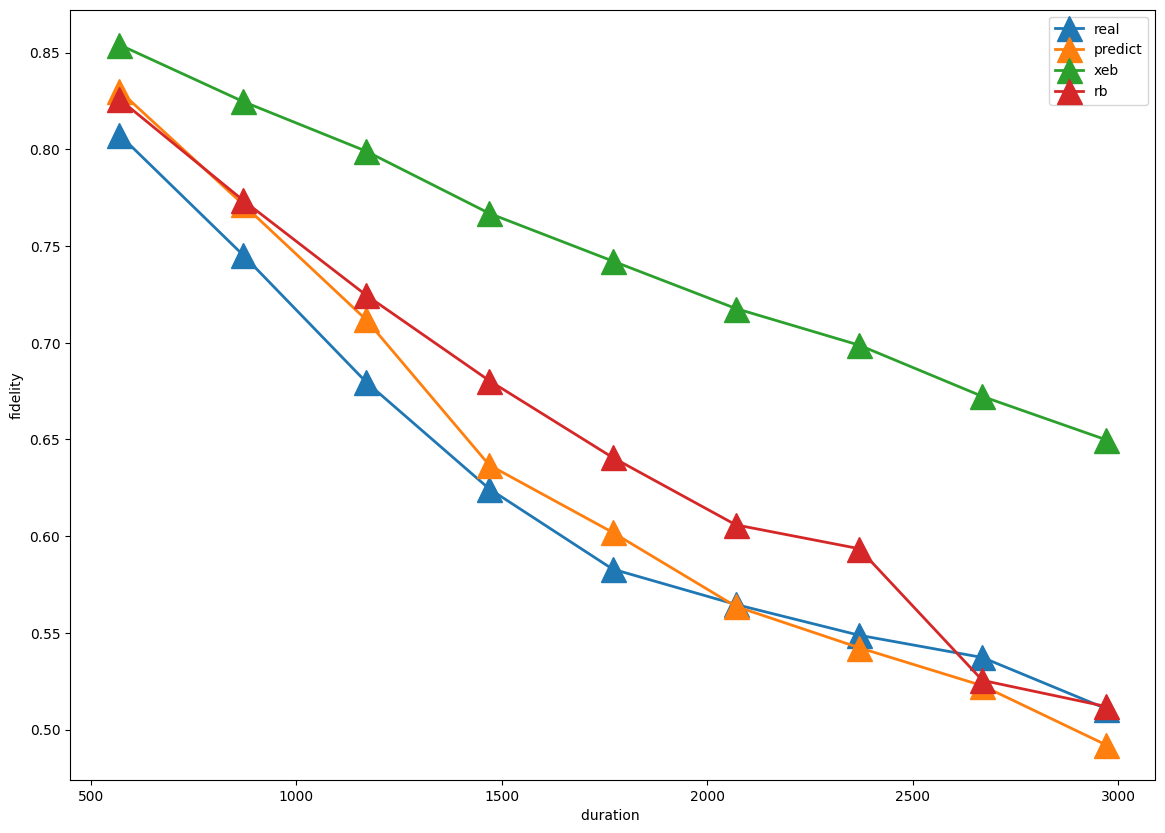

In [30]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    real_y.append(reals[circuit_index].mean())
    predict_y.append(predicts[circuit_index].mean())
    xeb_y.append(xebs[circuit_index].mean())
    rb_y.append(rbs[circuit_index].mean())
    
    _real.append(reals[circuit_index])
    _predict.append(predicts[circuit_index])
    _xeb.append(xebs[circuit_index])
    _rb.append(rbs[circuit_index])

rb_y = np.array(rb_y) - 0.12
xeb_y = np.array(xeb_y) - 0.12
predict_y = np.array(predict_y)
real_y = np.array(real_y)
 
axes.scatter(duration_X, real_y)
axes.plot(duration_X, real_y ,markersize = 18,linewidth = 2, label='real',marker = '^' )
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )


axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit/step1/duration_fidelity_execute_18bits_train_0_2500_step1.svg")  # step


In [5]:
predicts =[0.4658812880516052, 0.12107148766517639, 0.11097008734941483, 0.32076185941696167, 0.042933329939842224, 0.10819399356842041, 0.11913399398326874, 0.13318322598934174, 0.15415100753307343, 0.13040390610694885, 0.009010989218950272, 0.09964253008365631, 0.0595841109752655, 0.059569429606199265, 0.007964406162500381, 0.061573974788188934, 0.11724910885095596, 0.10209789872169495, 0.3051062822341919, -0.004890613257884979, -0.005122371017932892, 0.1267150491476059, 0.05104260891675949, -0.008990630507469177, -0.02850499004125595, 0.1287132203578949, 0.20050446689128876, -0.0010335370898246765, 0.21027345955371857, 0.09580297023057938, 0.4063100814819336, 0.31226396560668945, 0.0739303007721901, 0.1783025711774826, 0.062055185437202454, 0.0033919699490070343, -0.007106751203536987, 0.21198594570159912, 0.1591286063194275, -0.018491633236408234, 0.032650820910930634, 0.0878089889883995, 0.4010913372039795, 0.03185379505157471, 0.12239467352628708, 0.011003606021404266, 0.0571359246969223, 0.20300735533237457, 0.016365792602300644, 0.22909408807754517, 0.03170657157897949, -0.009068671613931656, 0.06338728964328766, 0.14574716985225677, 0.3851879835128784, 0.03378121554851532, 0.2033023089170456, 0.03864700347185135, 0.30740678310394287, 0.10795032978057861, 0.39329779148101807, 0.25614169239997864, 0.26345163583755493, 0.11608997732400894, 0.423062801361084, 0.29932475090026855, 0.11277720332145691, 0.04166032373905182, 0.007618702948093414, 0.017116881906986237, 0.01566130295395851, 0.053125061094760895, 0.20547178387641907, 0.2707125246524811, 0.04969010502099991, 0.24885284900665283, 0.136172354221344, 0.016116663813591003, 0.2576349377632141, 0.33793485164642334, 0.14555823802947998, 0.13128766417503357, 0.018494268879294395, 0.040566615760326385, 0.02450997196137905, 0.04103906825184822, 0.04092562943696976, 0.09506233036518097, 0.024457842111587524, 0.13373388350009918, 0.005192309617996216, 0.11487571150064468, 0.05355299636721611, -0.017270877957344055, 0.08964287489652634, 0.05902540683746338, 0.21881799399852753, 0.06750483810901642, 0.30589741468429565, 0.01167307049036026, 0.40036290884017944, 0.07259519398212433, 0.17173342406749725, 0.25651437044143677, -0.00738825649023056, -0.005601644515991211, 0.06528984010219574, 0.035603124648332596, 0.21187816560268402, 0.09623920917510986, -0.009951069951057434, 0.2156081646680832, 0.026247438043355942, 0.02901104837656021, -0.013236619532108307, 0.031232327222824097, 0.2253161072731018, 0.1836973875761032, 0.28746020793914795, 0.24028097093105316, 0.1491442769765854, 0.2600150406360626, 0.322298526763916, 0.07085613906383514, 0.24220314621925354, 0.1985592246055603, 0.00022786110639572144, 0.20696604251861572, -0.008943524211645126, 0.3952655792236328, 0.3078863024711609, 0.01570206508040428, 0.15394754707813263, 0.10626387596130371, 0.008741900324821472, 0.020741403102874756, 0.23925746977329254, 0.005120962858200073, 0.10409698635339737, 0.10442958027124405, 0.11365986615419388, -0.010271444916725159, 0.022781575098633766, 0.08246810734272003, 0.1732373684644699, 0.3245573043823242, 0.24641947448253632, 0.04981604963541031, 0.052328601479530334, 0.22231672704219818, -0.036190979182720184, 0.12753914296627045, 0.01744535192847252, 0.19099268317222595, 0.1567002534866333, 0.4372294545173645, 0.11211127042770386, 0.10213290899991989, 0.3796370029449463, 0.3233764171600342, 0.44582122564315796, -0.01595989614725113, -0.005634307861328125, 0.05562509223818779, 0.1807681918144226, 0.13195577263832092, 0.08416422456502914, 0.014367759227752686, 0.012359559535980225, 0.3260124921798706, 0.2792397141456604, 0.0689099133014679, 0.3337191939353943, 0.06928850710391998, 0.3472731113433838, 0.0855972021818161, 0.1634005606174469, -0.010152377188205719, 0.3388236165046692, 0.08068937808275223, 0.02820170484483242, 0.28197169303894043, 0.26094114780426025, 0.20298103988170624, 0.08846613019704819, -0.0180370956659317, 0.021410048007965088, 0.01026277244091034, 0.18322275578975677, 0.045486632734537125, 0.3503807783126831, 0.11343187838792801, 0.26204007863998413, 0.40529918670654297, 0.4299514889717102, 0.02768862619996071, 0.0301835760474205, 0.07299789786338806, 0.034484680742025375, 0.12001369148492813, 0.059532150626182556, 0.3296195864677429, 0.35080909729003906, 0.21518035233020782, 0.009467273950576782, 0.08467388153076172, 0.07423114031553268, 0.1877557933330536, 0.22041405737400055, 0.21447981894016266, 0.04058663174510002, 0.07186192274093628, 0.026084307581186295, -0.016088813543319702, -0.008777905255556107, 0.3805690407752991, 0.20037515461444855, 0.06729284673929214, 0.03811480104923248, -0.015135332942008972, 0.06332266330718994, 0.11006138473749161, 0.18827947974205017, 0.06281760334968567, 0.1558031141757965, 0.01102808490395546, 0.028612546622753143, 0.3749975562095642, 0.012261409312486649, 0.04559671878814697, 0.017250780016183853, 0.016948629170656204, 0.22105617821216583, 0.20587928593158722, -0.00048403069376945496, -0.021635115146636963, 0.07724250853061676, 0.2978079319000244, 0.0147160105407238, 0.13857045769691467, 0.2637624740600586, 0.07908301800489426, -0.0020753853023052216, 0.20702892541885376, 0.05589066073298454, 0.14897650480270386, 0.18777641654014587, 0.030755307525396347, 0.23707543313503265, 0.09663218259811401, 0.11682238429784775, 0.20024095475673676, 0.41337651014328003, 0.1411844938993454, 0.011956416070461273, 0.1276147961616516, 0.028143879026174545, 0.009365484118461609, 0.03397510200738907, 0.09074230492115021, 0.12255378812551498, 0.13280591368675232, 0.04293759912252426, 0.10520147532224655, 0.1675839126110077, 0.30738168954849243, 0.12311593443155289, 0.19711792469024658, 0.0319841206073761, 0.2698444128036499, 0.06502918154001236, 0.08203279972076416, -0.011086490005254745, 0.3865501880645752, 0.20513595640659332, 0.27836349606513977, 0.12179489433765411, 0.005247976630926132, 0.2524702548980713, 0.2164090871810913, -0.000868331640958786, 0.3517659306526184, -0.0001742057502269745, 0.4066809415817261, 0.06306511163711548, 0.3470879793167114, 0.4677172899246216, 0.1240578144788742, 0.01547456718981266, 0.006077229976654053, 0.06633444875478745, -0.02561337500810623, -0.024317666888237, 0.025343501940369606, 0.12667790055274963, 0.0077307261526584625, 0.06429751217365265, 0.01753341779112816, 0.07257436215877533, 0.10187892615795135, 0.16564390063285828, 0.010513052344322205, -0.0036770254373550415, 0.16901251673698425, -0.008199743926525116, 0.01924007013440132, 0.25000834465026855, 0.10918864607810974, 0.1624557077884674, 0.021352985873818398, 0.19731676578521729, 0.1340213567018509, 0.2213830053806305, 0.17823666334152222, 0.11608999967575073, 0.20834580063819885, 0.007994845509529114, -0.008508637547492981, 0.014342132955789566, 0.0025272704660892487, 0.02489290200173855, 0.26634564995765686, 0.2402404546737671, 0.018922675400972366, 0.11582531780004501, 0.2189038097858429, 0.2049534171819687, 0.008547335863113403, 0.024829158559441566, 0.026578210294246674, -0.028540320694446564, 0.09045527875423431, 0.13174912333488464, 0.013592451810836792, 0.2325349748134613, 0.11732504516839981, 0.10031846910715103, 0.010131221264600754, 0.33065104484558105, 0.25344666838645935, -0.004269890487194061, -0.013040874153375626, 0.028303340077400208, 0.27707380056381226, 0.09737850725650787, 0.12992876768112183, 0.06078720465302467, 0.41940003633499146, 0.20779281854629517, 0.08951500058174133, 0.08162574470043182, 0.32012009620666504, 0.10642045736312866, 0.025732770562171936, 0.3718702793121338, 0.15661850571632385, -0.021337516605854034, 0.011544786393642426, 0.014788568019866943, 0.4295812249183655, 0.13858336210250854, 0.02845761924982071, 0.11758161336183548, 0.1159898042678833, 0.07416416704654694, 0.006468590348958969, 0.18430614471435547, 0.31177228689193726, 0.013074800372123718, 0.024017706513404846, 0.0804121196269989, 0.2965773344039917, 0.14928536117076874, 0.16734090447425842, 0.3406883478164673, 0.3294927477836609, 0.11434488743543625, 0.2464134693145752, -0.018435828387737274, 0.07995285838842392, 0.2223401814699173, 0.03741053119301796, 0.02031007781624794, 0.17939330637454987, 0.23965401947498322, 0.38226431608200073, 0.060188546776771545, 0.18401461839675903, 0.022495504468679428, 0.024292685091495514, 0.20551590621471405, 0.051622334867715836, 0.0049024298787117004, 0.0021461471915245056, 0.21338583528995514, 0.1451733410358429, 0.06872318685054779, 0.0609978586435318, 0.37935012578964233, 0.01897255890071392, 0.2251867949962616, 0.2108508199453354, 0.21142767369747162, -0.010540805757045746, 0.06083175912499428, 0.0465141236782074, 0.12196330726146698, 0.09007714688777924, 0.21075910329818726, 0.16741985082626343, -0.006330385804176331, 0.10687804967164993, 0.4136096239089966, 0.016070079058408737, 0.01949949935078621, -0.012155257165431976, 0.14303763210773468, 0.058640867471694946, 0.010225966572761536, 0.014964580535888672, 0.37973690032958984, 0.0010046549141407013, 0.1461203247308731, -0.010571829974651337, 0.08052477240562439, 0.07979945838451385, 0.12911242246627808, 0.1691838800907135, 0.25475722551345825, 0.1303442269563675, 0.023611104115843773, 0.017382552847266197, 0.02030595764517784, 0.08344748616218567, 0.024625379592180252, 0.13041795790195465, 0.19207920134067535, 0.01283583790063858, 0.06359846144914627, 0.04042061045765877, 0.013835620135068893, 0.38875657320022583, -0.0019604675471782684, -0.011519506573677063, 0.45220452547073364, 0.2194417268037796, 0.07184659689664841, 0.12038412690162659, 0.19242534041404724, 0.343880295753479, 0.2962764501571655, 0.19332186877727509, 0.24998043477535248, 0.20896190404891968, 0.15332314372062683, 0.1030588448047638, 0.08921471983194351, 0.04309222847223282, 0.07039399445056915, 0.06169535964727402, 0.18552668392658234, 0.13035906851291656, 0.007813967764377594, 0.10117343068122864, 0.02006756141781807, 0.02870946377515793, 0.14749100804328918, 0.41204047203063965, 0.26485902070999146, 0.336577832698822, -0.018964193761348724, 0.21368257701396942, 0.26439952850341797, 0.11827611923217773, 0.012417521327733994, 0.037037137895822525, 0.03783777356147766, 0.18499837815761566, 0.00986507534980774, 0.1003049984574318, 0.1497941017150879, 0.012013629078865051, 0.37695473432540894, 0.08516449481248856, 0.1664401888847351, 0.07465115189552307, 0.06787778437137604, 0.20763243734836578, 0.30636048316955566, 0.08090595155954361, 0.1449134349822998, 0.0545232780277729, 0.4141803979873657, 0.04540511220693588, 0.4016433358192444, 0.11639270931482315, 0.01254294440150261, 0.3078165054321289, 0.03125365823507309, 0.008227646350860596, 0.06055380403995514, 0.07462212443351746, 0.28648868203163147, 0.2316245436668396, 0.3588132858276367, 0.3613678812980652, 0.31244999170303345, 0.10542641580104828, 0.33674561977386475, 0.3903358578681946, 0.4558486342430115, 0.35249167680740356, 0.06121071055531502, 0.07517629116773605, -0.05746816098690033, 0.1649121642112732, 0.06650914251804352, 0.04544852301478386, 0.044151369482278824, 0.061117351055145264, 0.38951581716537476, 0.011730466037988663, 0.45202112197875977, 0.42532551288604736, 0.35911494493484497, 0.2261841744184494, -0.016974225640296936, 0.3518514633178711, 0.18132975697517395, -0.00638420507311821, 0.030472807586193085, 0.18819807469844818, 0.009350486099720001, 0.13282951712608337, 0.1239854171872139, 0.23614715039730072, 0.26221296191215515, 0.24119709432125092, 0.06330326199531555, 0.18165452778339386, 0.11066010594367981, 0.02377188578248024, 0.1302381455898285, 0.102521151304245, 0.28489986062049866, 0.023680217564105988, 0.07440631091594696, 0.04298001155257225, 0.3389067053794861, 0.12540650367736816, 0.25925904512405396, 0.06289215385913849, -0.018153756856918335, 0.26294082403182983, 0.03945200890302658, 0.068173348903656, 0.17095305025577545, 0.19840936362743378, 0.25850653648376465, 0.03613174334168434, 0.15743428468704224, 0.025914259254932404, 0.015905629843473434, 0.26796644926071167, 0.23250073194503784, 0.2163517326116562, -0.010069791227579117, 0.05284275487065315, 0.3362143039703369, 0.020289817824959755, 0.2786714434623718, 0.15907490253448486, 0.09164676815271378, 0.008637573570013046, 0.003971479833126068, 0.17654259502887726, 0.026224184781312943, 0.15449285507202148, 0.42622727155685425, 0.05000248923897743, -0.022081196308135986, 0.3783709406852722, 0.07017631828784943, 0.03280886262655258, 0.26949572563171387, 0.17441289126873016, 0.26768529415130615, 0.02341427281498909, 0.2125157117843628, -0.01723010092973709, 0.18853960931301117, 0.09591750800609589, 0.09769223630428314, 0.04007269814610481, 0.17099612951278687, 0.31796908378601074, 0.1571466028690338, 0.16102582216262817, 0.3104094862937927, 0.06340103596448898, 0.23745140433311462, 0.016482342034578323, 0.043664973229169846, -0.02599693089723587, 0.02979307435452938, 0.029465094208717346, 0.04910621792078018, 0.02076708897948265, 0.07359091937541962, 0.08739157021045685, 0.09703686088323593, -0.001998741179704666, 0.3349549174308777, 0.40015774965286255, 0.12676483392715454, 0.20027925074100494, 0.35341447591781616, 0.13806375861167908, 0.1101132184267044, 0.05911020562052727, 0.012372985482215881, 0.2525438964366913, 0.259907603263855, 0.013385538011789322, 0.10506823658943176, 0.2057822346687317, 0.12911349534988403, 0.3101387619972229, 0.08052441477775574, 0.3256245255470276, 0.15046000480651855, 0.02958722412586212, 0.16512618958950043, 0.062380775809288025, 0.0033091269433498383, 0.046335458755493164, 0.17410363256931305, 0.1754624843597412, 0.03970366343855858, 0.37368035316467285, 0.08776172995567322, 0.40238600969314575, 0.08243080973625183, 0.020923923701047897, 0.19610606133937836, -0.006301775574684143, -0.003814302384853363, 0.3418269753456116, 0.13049939274787903, 0.03247557207942009, 0.08874359726905823, 0.0241793692111969, -0.004542678594589233, 0.1831594854593277, 0.2573752999305725, 0.3736528754234314, 0.024048369377851486, 0.027038171887397766, 0.2038782238960266, 0.1899806261062622, 0.0536663644015789, 0.04476412385702133, 0.2489396035671234, -0.0013559088110923767, 0.039641086012125015, 0.017218366265296936, 0.3328835368156433, 0.019687524065375328, 0.020352104678750038, -0.022576995193958282, 0.06843307614326477, 0.11769915372133255, 0.22035986185073853, 0.1991487443447113, 0.09928987920284271, 0.08660329878330231, 0.02767244353890419, 0.0955955982208252, 0.0816163644194603, 0.05483720824122429, 0.32813721895217896, 0.022032270208001137, 0.04497168958187103, -0.005239937454462051, 0.029448486864566803, 0.29585155844688416, -0.00011473521590232849, 0.23342017829418182, 0.13776496052742004, -0.019561655819416046, 0.22724100947380066, 0.044733718037605286, 0.00835508108139038, 0.2819102108478546, 0.0247912909835577, 0.03347145393490791, -0.0031868591904640198, -0.001225292682647705, 0.34195083379745483, 0.019600393250584602, 0.14275658130645752, 0.11276883631944656, 0.10462796688079834, 0.029640235006809235, 0.2886750400066376, 0.2910807132720947, 0.020488552749156952, 0.05682474747300148, 0.3113754391670227, 0.3399810791015625, 0.03454441949725151, 0.0007219314575195312, 0.1894286423921585, -0.030892930924892426, -0.019474536180496216, 0.3690696954727173, 0.16380125284194946, -0.027503475546836853, 0.28657209873199463, 0.11029857397079468, 0.11448248475790024, 0.06770901381969452, 0.16669538617134094, 0.37806594371795654, 0.018743548542261124, 0.10604304075241089, 0.34330636262893677, 0.23599278926849365, -0.011475473642349243, -0.007149998098611832, 0.021426502615213394, 0.2228664606809616, 0.35027289390563965, 0.07118658721446991, 0.08302631974220276, 0.37110066413879395, 0.06775490939617157, 0.2028459757566452, 0.030994512140750885, 0.06330826878547668, 0.14605678617954254, 0.08028563857078552, 0.339738667011261, 0.21210457384586334, 0.2216448336839676, 0.1395876109600067, 0.007402133196592331, 0.31152284145355225, 0.03336534649133682, 0.25023865699768066, 0.029337331652641296, -0.0022488944232463837, 0.0005006454885005951, 0.1311444640159607, 0.20514406263828278, 0.05891486257314682, -0.019620224833488464, 0.021624069660902023, 3.6619603633880615e-05, 0.23190219700336456, 0.27771276235580444, 0.39531058073043823, 0.17249944806098938, 0.031730011105537415, 0.11221207678318024, 0.07104863226413727, 0.1877029985189438, 0.3339991569519043, 0.22231507301330566, 0.03712114691734314, 0.035088248550891876, 0.2641482949256897, 0.37165015935897827, 0.03641774132847786, 0.12747886776924133, 0.2323978841304779, 0.20773567259311676, 0.03114640899002552, 0.009553015232086182, 0.009576316922903061, 0.0298304483294487, 0.02132478728890419, 0.12625837326049805, -2.516806125640869e-05, 0.41946929693222046, 0.3459174633026123, 0.0857858657836914, 0.002175804227590561, 0.21556827425956726, 0.18908844888210297, 0.12755967676639557, 0.14855584502220154, 0.011632934212684631, 0.17807631194591522, 0.09249911457300186, 0.026220791041851044, 0.10890798270702362, 0.1052323430776596, 0.03264953941106796, -0.0028386488556861877, 0.10388893634080887, 0.12156522274017334, 0.035467520356178284, 0.36833399534225464, 0.09752453118562698, 0.13569460809230804, 0.10873670130968094, 0.031407538801431656, -0.0037520378828048706, 0.13629211485385895, -0.019193030893802643, 0.09874425828456879, 0.13727037608623505, 0.0275343656539917, 0.10576141625642776, 0.040956344455480576, 0.4556395411491394, 0.11715620011091232, 0.017685914412140846, 0.44022029638290405, -0.008200179785490036, 0.3418683409690857, 0.04541198909282684, 0.11937274783849716, 0.057341866195201874, 0.20078939199447632, 0.16369467973709106, 0.022428087890148163, -0.006334982812404633, 0.03487697243690491, 0.025927405804395676, 0.05121447890996933, 0.27980655431747437, 0.18415923416614532, -0.02420501410961151, 0.025518294423818588, 0.04087410494685173, 0.23384340107440948, 0.1674601435661316, 0.4293139576911926, 0.10424980521202087, 0.02441656030714512, 0.09345179051160812, 0.3039014935493469, 0.020426463335752487, -0.011385567486286163, 0.09709785133600235, 0.344951331615448, 0.022957399487495422, 0.007013849914073944, 0.28993359208106995, 0.04502667486667633, 0.2409370392560959, 0.009835317730903625, 0.3727232813835144, 0.12672123312950134, 0.08683870732784271, -0.009985625743865967, -0.011345390230417252, 0.08792737126350403, 0.12428543716669083, 0.018792774528265, -0.013089895248413086, 0.001708008348941803, 0.28294140100479126, 0.13380637764930725, 0.26125451922416687, 0.12297641485929489, 0.264712393283844, 0.4092487096786499, 0.19570405781269073, 0.19698072969913483, 0.13199999928474426, 0.36326563358306885, 0.3371960520744324, 0.31644725799560547, 0.005104448646306992, 0.02317095175385475, 0.02603110671043396, 0.049663789570331573, 0.01828785240650177, 0.06780248880386353, 0.1277129352092743, 0.22408942878246307, 0.15061227977275848, 0.03808392211794853, 0.1602969467639923, 0.17424556612968445, 0.006293535232543945, 0.06501367688179016, 0.13732191920280457, 0.05482789874076843, 0.16671913862228394, 0.3172531723976135, 0.24739323556423187, 0.1014459952712059, -0.001683410257101059, -0.015562217682600021, 0.069401316344738, 0.09167832881212234, 0.12893128395080566, 0.2823849022388458, 0.28037047386169434, 0.3505401611328125, 0.060963090509176254, -0.005761869251728058, 0.3054329752922058, 0.13442952930927277, 0.4151960015296936, 0.03397509455680847, 0.05878729745745659, 0.03600723296403885, 0.30971962213516235, 0.05107685923576355, 0.09571509808301926, 0.05570889636874199, 0.10256422311067581, 0.02152899280190468, 0.25720465183258057, 0.05318363010883331, 0.03872647508978844, 0.06100507825613022, 0.11150050908327103, 0.05025191977620125, -0.03210774064064026, 0.31298667192459106, -0.026485100388526917, 0.13787715137004852, 0.20694518089294434, 0.00810438022017479, 0.2317323386669159, 0.08301613479852676, 0.08975572884082794, 0.26692718267440796, 0.2811463475227356, 0.09994843602180481, 0.2343774139881134, 0.37975025177001953, 0.3984493613243103, 0.17339405417442322, 0.10193745791912079, 0.05357632786035538, 0.25543129444122314, 0.01070355623960495, 0.3466007113456726, 0.18968363106250763, 0.24607409536838531, 0.0038264617323875427, -0.02689998596906662, 0.10237116366624832, 0.06197025254368782, 0.3339780569076538, 0.02463730052113533, 0.006187357008457184, 0.14916135370731354, 0.1601552963256836, 0.05720331147313118, 0.037729643285274506, 0.07500803470611572, 0.04401269927620888, 0.18851381540298462, 0.009145453572273254, 0.029921818524599075, 0.012203894555568695, 0.24191628396511078, 0.42425841093063354, 0.41501808166503906, 0.011033080518245697, 0.28356271982192993, 0.07649313658475876, 0.02419723942875862, 0.20773938298225403, 0.09640902280807495, -0.03620225936174393, 0.2387695610523224, 0.30018359422683716, 0.25604328513145447, 0.09600557386875153, 0.03758279234170914, 0.17272251844406128, 0.0033116191625595093, 0.10775497555732727, 0.19048380851745605, 0.04808914661407471, 0.15316732227802277, 0.3891472816467285, 0.020495425909757614, 0.07918350398540497, 0.0773327499628067, 0.017253166064620018, 0.17497581243515015, 0.009852558374404907, 0.03854147344827652, 0.4122551679611206, 0.21940822899341583, 0.27696746587753296, 0.049693867564201355, 0.02275972068309784, 0.20660610496997833, 0.03760445490479469, 0.06769762933254242, 0.06504891067743301, 0.1691727191209793, 0.10434138029813766, 0.3466644883155823, 0.04539612680673599, 0.02308489754796028, 0.061392709612846375, 0.04798486456274986, -0.007724527269601822, -0.00020916014909744263, 0.028160927817225456, 0.18474824726581573, 0.03176740184426308, 0.05856258422136307, 0.11257248371839523, 0.21018706262111664, 0.2502136826515198, 0.08322400599718094, 0.288432776927948, 0.07507210224866867, 0.1389910876750946, 0.2783427834510803, 0.030809855088591576, 0.19601473212242126, 0.10594815015792847, 0.06057489663362503, 0.06551940739154816, -0.011438950896263123, 0.32250434160232544, 0.26703065633773804, 0.0441531278192997, 0.1413254737854004, 0.2341378778219223, 0.33238714933395386, 0.046391408890485764, 0.033168233931064606, 0.09755731374025345, 0.0009387806057929993, 0.3726652264595032, 0.13959039747714996, 0.10254603624343872, 0.26473599672317505, 0.039017949253320694, 0.14798419177532196, 0.25554656982421875, 0.11503864824771881, 0.0790015161037445, 0.34589576721191406, 0.3140276074409485, 0.0963853970170021, 0.050656188279390335, 0.37207895517349243, 0.17259405553340912, 0.09279178828001022, 0.19038626551628113, 0.02406339719891548, 0.04720328748226166, 0.015099942684173584, 0.3719736337661743, 0.3281991481781006, -0.02181529998779297, 0.01388988271355629, 0.14705950021743774, 0.1298547089099884, 0.26143649220466614, 0.23457640409469604, 0.3390401005744934, 0.10416565835475922, 0.10326670855283737, 0.3259139060974121, 0.03421858325600624, 0.2145186960697174, 0.021860916167497635, 0.2701636850833893, 0.16359931230545044, 0.33566373586654663, 0.011956475675106049, 0.10807323455810547, 0.12431909888982773, 0.06226249039173126, 0.25629037618637085, 0.0411481112241745, 0.06589287519454956, -0.007755592465400696, 0.0470699779689312, 0.11316625773906708, 0.188099667429924, 0.14980722963809967, 0.01882937178015709, 0.008383341133594513, 0.026095276698470116, 0.08475637435913086, 0.2274187207221985, -0.007359687238931656, 0.24191978573799133, 0.0036286748945713043, 0.16599798202514648, 0.37026387453079224, 0.3485580086708069, 0.007114332169294357, 0.012518838047981262, 0.03168458491563797, 0.05405982583761215, 0.2569052577018738, 0.2258671373128891, 0.023680321872234344, 0.07169473171234131, 0.2963384985923767, 0.10209394991397858, 0.012677684426307678, 0.09036539494991302, 0.2748134136199951, 0.1280122697353363, 0.2757781744003296, 0.06801477819681168, 0.0962524563074112, 0.08002760261297226, 0.11678445339202881, 0.06539136171340942, 0.45869219303131104, 0.0071802809834480286, 0.10057607293128967, 0.05404280871152878, 0.08961285650730133, 0.2160983681678772, 0.31419825553894043, 0.3074425458908081, 0.1647714227437973, 0.004648640751838684, 0.028454160317778587, 0.2182571440935135, 0.1819203794002533, 0.2698158025741577, 0.4293815493583679, -0.019759401679039, 0.1285632848739624, 0.2269459217786789, 0.010230503976345062, 0.4052514433860779, -0.030739545822143555, 0.03075786679983139, 0.3366004228591919, 0.15452653169631958, 0.015595540404319763, 0.3534431457519531, -0.0022697262465953827, 0.2344737946987152, 0.0858779102563858, 0.24941062927246094, 0.02456161193549633, 0.36125606298446655, 0.13832227885723114, 0.40673476457595825, 0.16128483414649963, 0.3822597861289978, 0.05785265192389488, 0.09731602668762207, 0.3539886474609375, -0.012519411742687225, 0.06113485246896744, 0.28029173612594604, 0.1729436069726944, 0.09313192963600159, 0.03802977502346039, 0.051120057702064514, 0.08542830497026443, 0.17398232221603394, 0.11976113170385361, 0.015657901763916016, 0.015932615846395493, 0.003176514059305191, 0.13563096523284912, 0.07679244130849838, 0.4110773801803589, 0.08637938648462296, 0.17945900559425354, 0.40219229459762573, 0.16107177734375, 0.1857781857252121, 0.12302739918231964, 0.3450307846069336, -0.027374178171157837, 0.06417596340179443, 0.08791252970695496, 0.03114250674843788, 0.0421147346496582, 0.18621790409088135, 0.1960008293390274, 0.015627112239599228, 0.24928779900074005, 0.03128857910633087, 0.11345275491476059, 0.3268424868583679, 0.11640235036611557, 0.016544673591852188, 0.12593404948711395, 0.40688127279281616, 0.08566480129957199, 0.1356770396232605, -0.035818539559841156, 0.14463597536087036, 0.31695836782455444, 0.008492816239595413, -0.0018404573202133179, 0.1745903491973877, 0.12168928235769272, 0.20014655590057373, 0.4485258460044861, 0.05303454399108887, 0.013736661523580551, -0.01740814745426178, 0.3733673691749573, 0.009639527648687363, 0.16255700588226318, -0.00584082305431366, 0.20521514117717743, 0.25653016567230225, 0.02025444433093071, 0.2668991982936859, 0.16942012310028076, 0.1596442013978958, 0.007754780352115631, 0.3705427646636963, 0.05219630151987076, 0.007057368755340576, 0.0036973394453525543, 0.007654935121536255, 0.08548644185066223, 0.4315527677536011, 0.27559220790863037, 0.015939000993967056, -0.0209072083234787, 0.07910425961017609, 0.14934740960597992, 0.1628859043121338, 0.20572486519813538, -0.0104556605219841, 0.09997100383043289, 0.011308986693620682, 0.0435054674744606, 0.3720654249191284, 0.05336304008960724, 0.04979743808507919, 0.28042125701904297, 0.02557079866528511, 0.29371267557144165, 0.2584962844848633, 0.0355861559510231, 0.12500572204589844, 0.21951155364513397, 0.09738541394472122, 0.020202862098813057, 0.014953352510929108, 0.2617247700691223, 0.127700537443161, 0.06145583838224411, 0.31371843814849854, 0.04035428911447525, 0.17323237657546997, 0.04071672633290291, 0.09608831256628036, 0.1414094716310501, 0.17469464242458344, -0.005731165409088135, 0.053129199892282486, 0.12159693986177444, 0.2793748378753662, 0.10318928211927414, 0.2060881108045578, 0.1843734085559845, 0.01744467206299305, 0.13576442003250122, -0.00028924643993377686, 0.35433411598205566, 0.2720394730567932, 0.43815600872039795, 0.06345924735069275, 0.34500056505203247, 0.042511265724897385, 0.007890254259109497, 0.17860187590122223, 0.24325157701969147, 0.003994673490524292, 0.038937583565711975, 0.029090356081724167, -0.020099490880966187, 0.040187958627939224, 0.30624037981033325, 0.27601975202560425, 0.15068787336349487, 0.007787670940160751, 0.13159307837486267, 0.09200063347816467, 0.21436719596385956, 0.18674907088279724, 0.17618708312511444, 0.08094364404678345, -0.0009119920432567596, 0.0022765547037124634, 0.05379962548613548, 0.03941558673977852, 0.047433119267225266, 0.034635771065950394, 0.11294643580913544, -0.00907408818602562, 0.23474951088428497, 0.41401737928390503, 0.04312870651483536, 0.10276789963245392, 0.06048374995589256, 0.012866389006376266, 0.26944100856781006, 0.3533889055252075, 0.09835466742515564, 0.04144282266497612, 0.07465896755456924, -0.005197614431381226, 0.17864783108234406, 0.09558473527431488, 0.24142825603485107, 0.3716687560081482, 0.05643637105822563, 0.10583788901567459, 0.03031298890709877, 0.12042088806629181, 0.07157543301582336, 0.0751962810754776, 0.13168084621429443, 0.2017906904220581, 0.013032350689172745, 0.025514299049973488, 0.10282213985919952, 0.24388866126537323, 0.40380018949508667, 0.058553047478199005, 0.11773543059825897, 0.2383100688457489, 0.042513854801654816, 0.015697676688432693, -0.002826441079378128, -0.007888950407505035, 0.10464877635240555, 0.02201870083808899, 0.19061768054962158, 0.051990609616041183, 0.04306837543845177, 0.2968748211860657, 0.18510578572750092, 0.13474713265895844, 0.3040977716445923, 0.3432708978652954, 0.013915661722421646, 0.14044764637947083, 0.015314944088459015, 0.057062745094299316, 0.28050553798675537, 0.156810462474823, -0.014557573944330215, 0.12730944156646729, 0.004173509776592255, 0.3148810863494873, 0.04213111847639084, 0.2623315751552582, 0.003569073975086212, 0.22393953800201416, 0.04453807324171066, 0.006810195744037628, 0.3736577033996582, 0.14741840958595276, 0.242112398147583, 0.12974917888641357, 0.12381579726934433, 0.3032362461090088, 0.27870070934295654, 0.24192525446414948, -0.017910197377204895, 0.21096952259540558, 0.023152921348810196, 0.1697155386209488, 0.17705759406089783, 0.3296654224395752, 0.14759543538093567, 0.3260881304740906, 0.003818526864051819, 0.2275322526693344, 0.15329498052597046, 0.040434692054986954, 0.26181671023368835, 0.2984534502029419, 0.10203804075717926, 0.3469535708427429, 0.11237193644046783, 0.002934269607067108, 0.01306094229221344, 0.13484534621238708, 0.06318014860153198, 0.0836387574672699, 0.10752534866333008, 0.02430691197514534, 0.012539021670818329, -0.008490774780511856, 0.013445086777210236, 0.17886854708194733, 0.013203330338001251, 0.3822305202484131, 0.10867016762495041, 0.22968582808971405, 0.08235502243041992, 0.3031027913093567, 0.022632546722888947, 0.30659180879592896, 0.2139086276292801, 0.22723166644573212, 0.06347256153821945, 0.42873769998550415, 0.15857398509979248, 0.007139869034290314, 0.1126125380396843, 0.041971758008003235, 0.137150377035141, 0.10970205068588257, 0.0818949043750763, 0.10233211517333984, -0.01721351593732834, 0.1460573822259903, 0.2114601731300354, 0.23742756247520447, 0.17234449088573456, 0.28985458612442017, 0.395513117313385, 0.39134681224823, 0.15442286431789398, 0.1692465841770172, 0.01135798916220665, 0.08035717904567719, 0.08739512413740158, 0.06166099011898041, 0.25832271575927734, 0.05843561515212059, 0.36969250440597534, 0.4095016121864319, 0.3079964518547058, 0.06373602151870728, -0.003057636320590973, 0.10220402479171753, 0.08778153359889984, 0.24149127304553986, 0.29408109188079834, 0.0290498286485672, 0.25823473930358887, 0.07831777632236481, 0.2930492162704468, 0.053749602288007736, 0.06983306258916855, 0.03935505822300911, 0.18007294833660126, 0.15300188958644867, 0.08960572630167007, -0.009332031011581421, 0.011903300881385803, 0.034653425216674805, 0.015872834250330925, 0.2921980023384094, 0.23127368092536926, -0.0005008205771446228, 0.13703222572803497, 0.043639976531267166, 0.07167331874370575, 0.13181158900260925, 0.19340364634990692, 0.2777213454246521, 0.22692428529262543, -0.0030860789120197296, -0.01705349236726761, 0.35599613189697266, 0.053908154368400574, 0.09958057105541229, 0.03814727067947388, -0.023737840354442596, 0.055479831993579865, 0.061525795608758926, 0.07330240309238434, 0.33202117681503296, 0.43813782930374146, 0.0842355340719223, 0.07877446711063385, 0.12235485017299652, 0.053861718624830246, 0.1873430758714676, 0.37029457092285156, 0.20124028623104095, 0.07764856517314911, 0.2902953624725342, 0.3141941428184509, 0.01629302278161049, 0.11085334420204163, -0.02891571819782257, -0.002501152455806732, 0.04575410857796669]

[0.06957307319943183, 0.10345342509140856, 0.1230084622198429, 0.1180199406572307, 0.11498996477466611, 0.09268964172283509, 0.10548784705759448, 0.09973901544312636, 0.07514887077767739] [] []


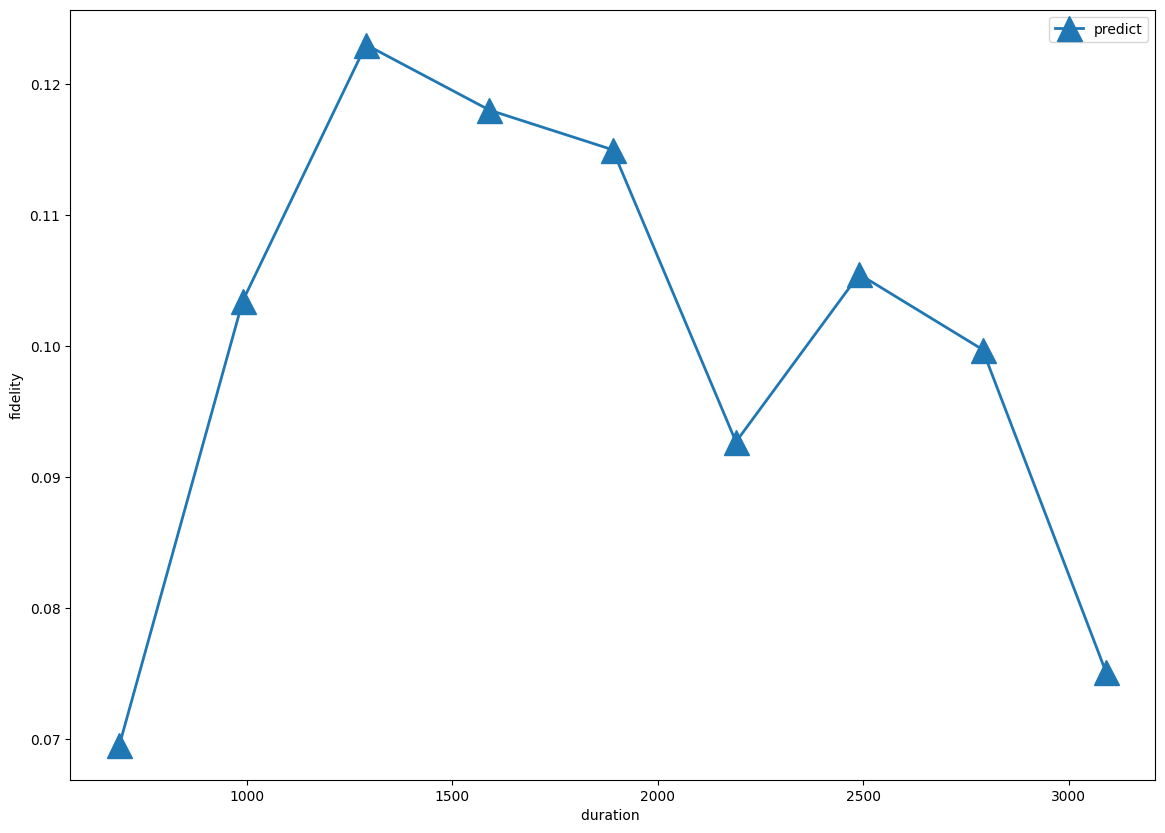

In [8]:
from plot.plot import get_duration2circuit_infos

predicts = np.array(predicts)
predicts = predicts + 0.9 - predicts.max()
fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).mean())
    # xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).mean())
    # rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).mean())
    


# rb_y = np.array(rb_y) - 0.12
# xeb_y = np.array(xeb_y) - 0.12
# predict_y = np.array(predict_y)
# real_y = np.array(real_y)
 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
# axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
# axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"sdgdshgh.svg")  # step


NameError: name 'xebs' is not defined

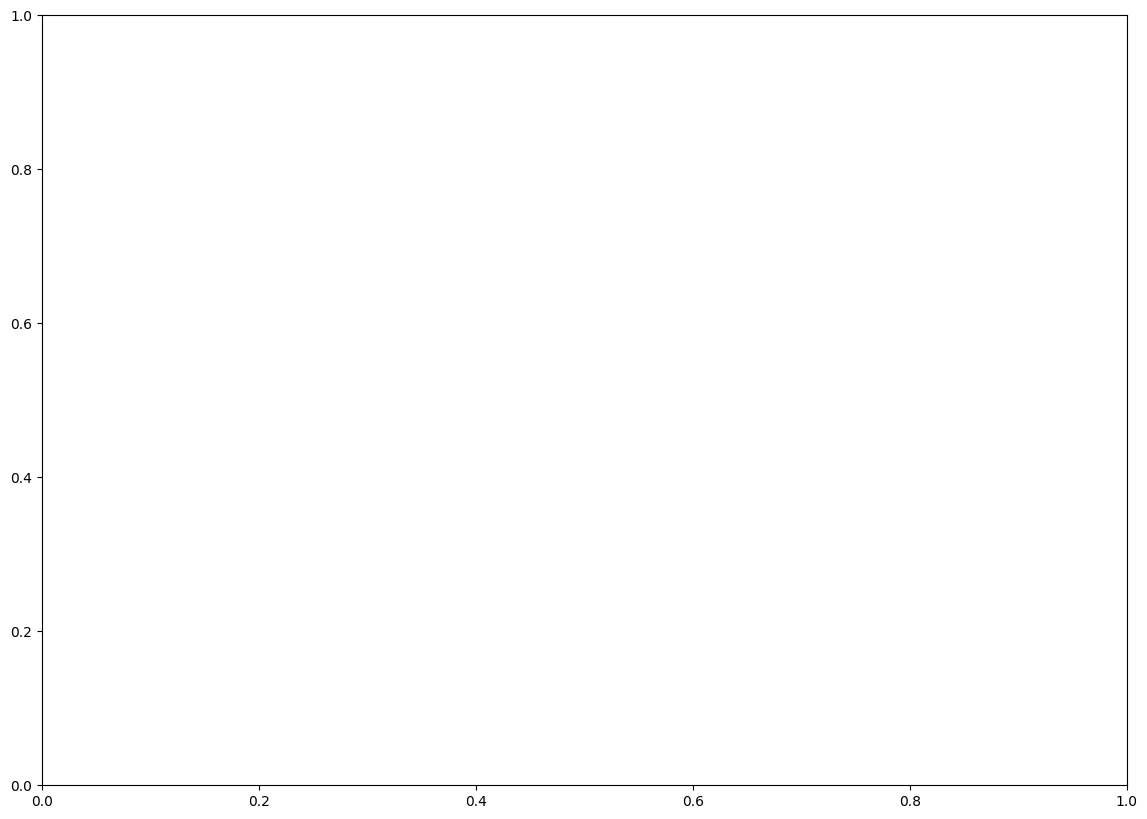

In [4]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).mean())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).mean())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).mean())
    


# rb_y = np.array(rb_y) - 0.12
# xeb_y = np.array(xeb_y) - 0.12
# predict_y = np.array(predict_y)
# real_y = np.array(real_y)
 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit/step1/duration_fidelity_execute_18bits_train_0_2500_step1_delta.svg")  # step


[0.03950960844673247, 0.05027686419962032, 0.04922207976998456, 0.05052600291667282, 0.04264817822307554, 0.04364362934960181, 0.04664608613415585, 0.04364745821847764, 0.0406139373617549] [0.06840569217666084, 0.10552954786347385, 0.10761684086584432, 0.10894451461317547, 0.10831733273025465, 0.11010748792624435, 0.1111927639367927, 0.10744399154007214, 0.09817577806217687] [0.0767131145626178, 0.09407016482923417, 0.09653087959340088, 0.10151276781786375, 0.10399411920133711, 0.10799352972180978, 0.10164528663279261, 0.10784417769851957, 0.11249148114619506]


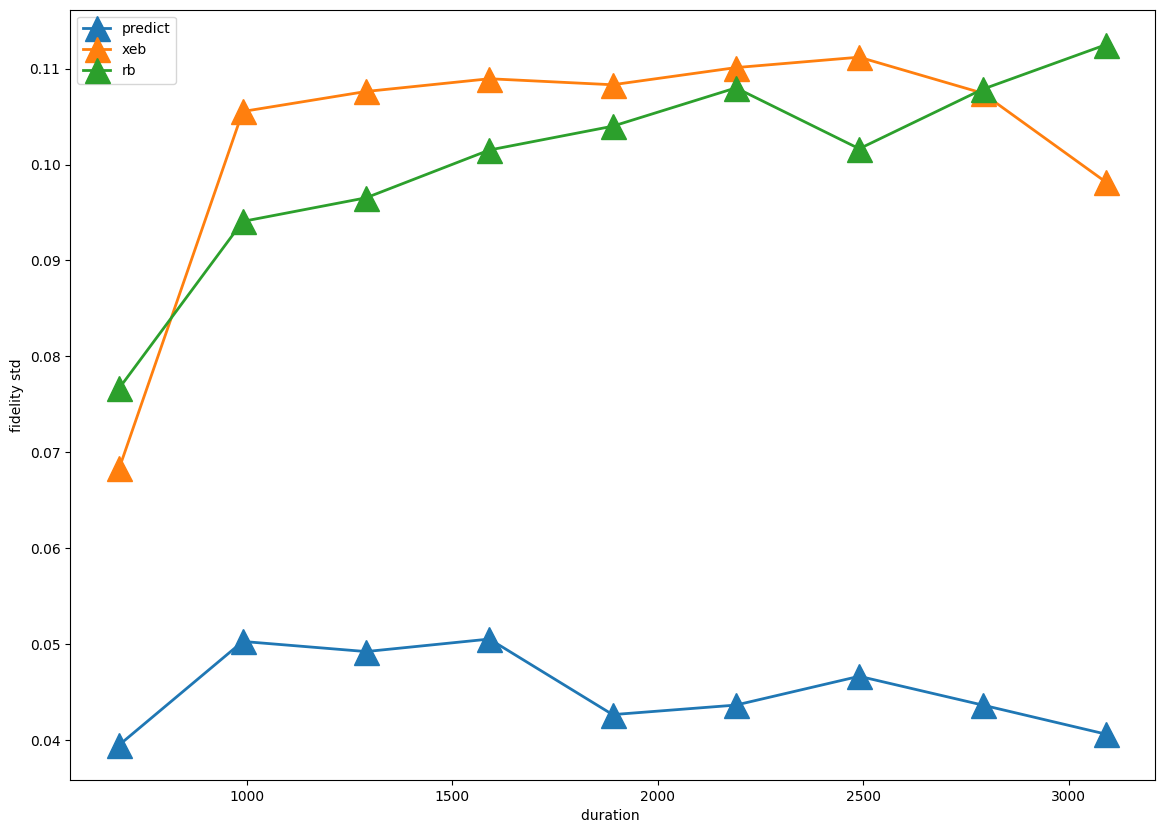

In [26]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).std())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).std())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).std())
    
xeb_y =[0.06840569217666084, 0.10552954786347385, 0.10761684086584432, 0.10894451461317547, 0.10831733273025465, 0.11010748792624435, 0.1111927639367927, 0.10744399154007214, 0.09817577806217687]

# rb_y = np.array(rb_y) - 0.12
# xeb_y = np.array(xeb_y) - 0.12
# predict_y = np.array(predict_y)
# real_y = np.array(real_y)
 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('fidelity std')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit_new/duration_fidelity_execute_18bits_train_0_2500_step1_delta.svg")  # step


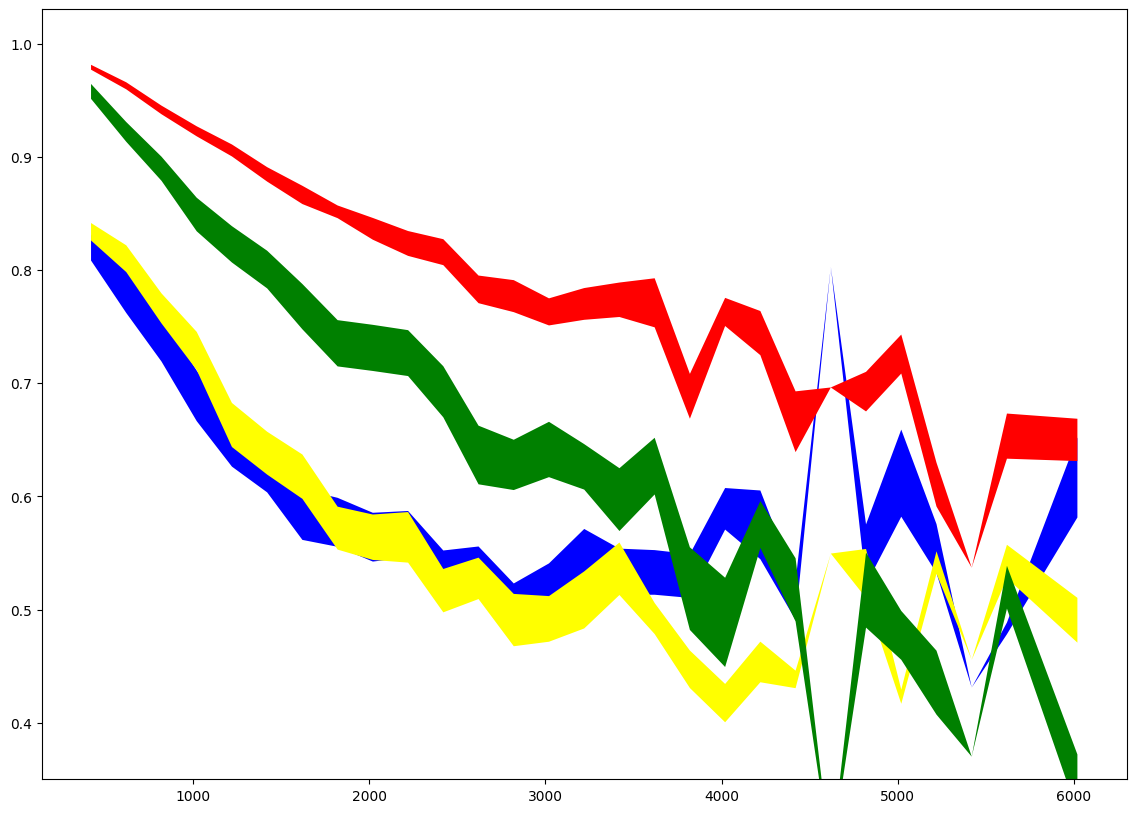

In [32]:
import seaborn as sns 

fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations, 200,0)

scale = 5
real_top,predict_top , xeb_top, rb_top= [],[],[], []
real_down,predict_down , xeb_down,  rb_down = [],[],[], []
for circuit_index in duration2circuit_index:
    real_top.append(reals[circuit_index].std()/scale*2)
    predict_top.append(predicts[circuit_index].std()/scale*2)
    xeb_top.append(xebs[circuit_index].std()/scale*2)
    rb_top.append(rbs[circuit_index].std()/scale*2)
    
    real_down.append(reals[circuit_index].mean() - reals[circuit_index].std()/scale)
    predict_down.append(predicts[circuit_index].mean() - predicts[circuit_index].std()/scale )
    xeb_down.append(xebs[circuit_index].mean()- xebs[circuit_index].std()/scale)
    rb_down.append(rbs[circuit_index].mean()- rbs[circuit_index].std()/scale)
    

# axes.stackplot(duration_X, [real_down,real_top], labels=['real'], colors=['white', (0, , 1, 0.5)])

# axes.stackplot(duration_X, [real_down,real_top], labels=['real'], colors=['white', 'blue'])
# axes.stackplot(duration_X, [predict_down,predict_top], labels=['real'], colors=['white', 'yellow'])
# axes.stackplot(duration_X, [xeb_down,xeb_top], labels=['real'], colors=['white', 'red'])
# axes.stackplot(duration_X, [rb_down, rb_top], labels=['real'], colors=['white', 'green'])

axes.stackplot(duration_X, [real_down,real_top], labels=['real'], colors=[(0, 0, 0, 0), 'blue'])
axes.stackplot(duration_X, [predict_down,predict_top], labels=['real'], colors=[(0, 0, 0, 0), 'yellow'])
axes.stackplot(duration_X, [xeb_down,xeb_top], labels=['real'], colors=[(0, 0, 0, 0), 'red'])
axes.stackplot(duration_X, [rb_down, rb_top], labels=['real'], colors=[(0, 0, 0, 0), 'green'])

axes.set_ylim(0.35)
fig.show()
fig.savefig(f"execute_18bit/step1/duration_fidelity_execute_18bits_train_0_2500_step1_stack.svg")  # step

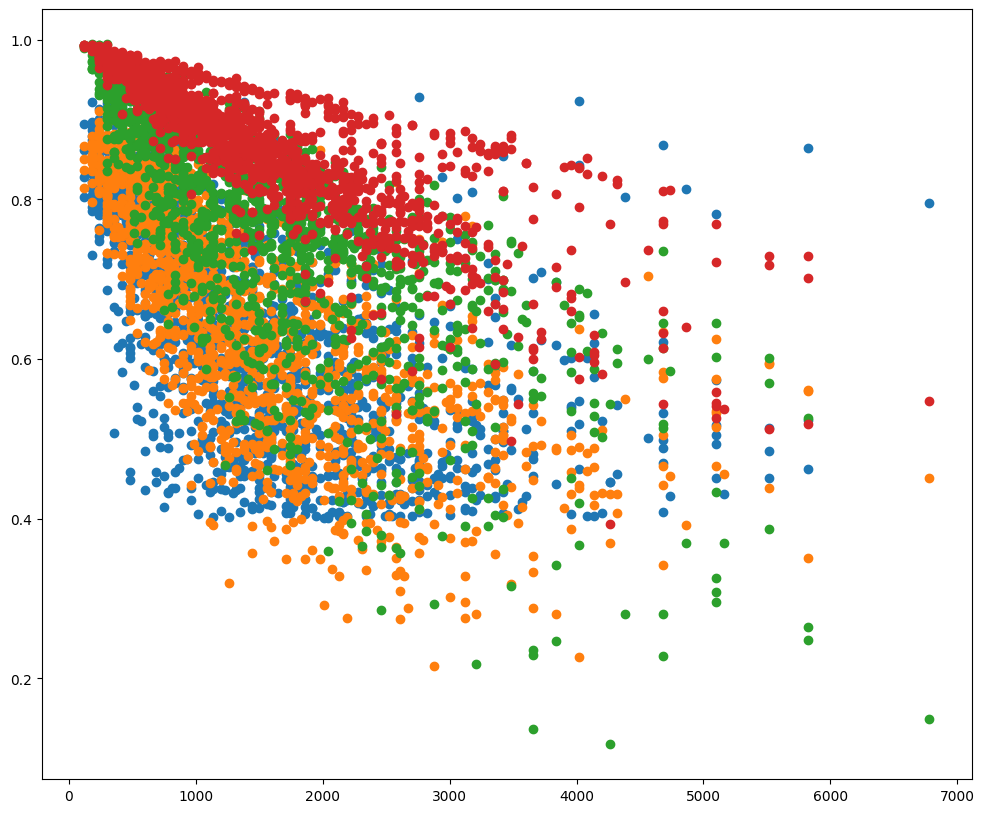

In [33]:
fig, axes = plt.subplots(figsize=(12, 10))
axes.scatter(durations,reals) 
axes.scatter(durations,predicts) 
axes.scatter(durations,rbs) 
axes.scatter(durations,xebs) 

[0.05276566362380982, 0.05898275556472631, 0.06247927789963208, 0.06505444665011403, 0.07280154797795055, 0.07687986758292117, 0.07212217626382003, 0.09075324907796135] [0.28419092265358087, 0.22138776782850178, 0.24198945897862867, 0.24499252443499928, 0.2721029094120415, 0.24349527222868333, 0.24924419321241256, 0.22392572606872482] [0.25153626063250606, 0.19029405850211878, 0.18715648209165253, 0.18275904605709498, 0.17562330858524824, 0.16554976283125875, 0.16607146391313143, 0.14163046338511542]


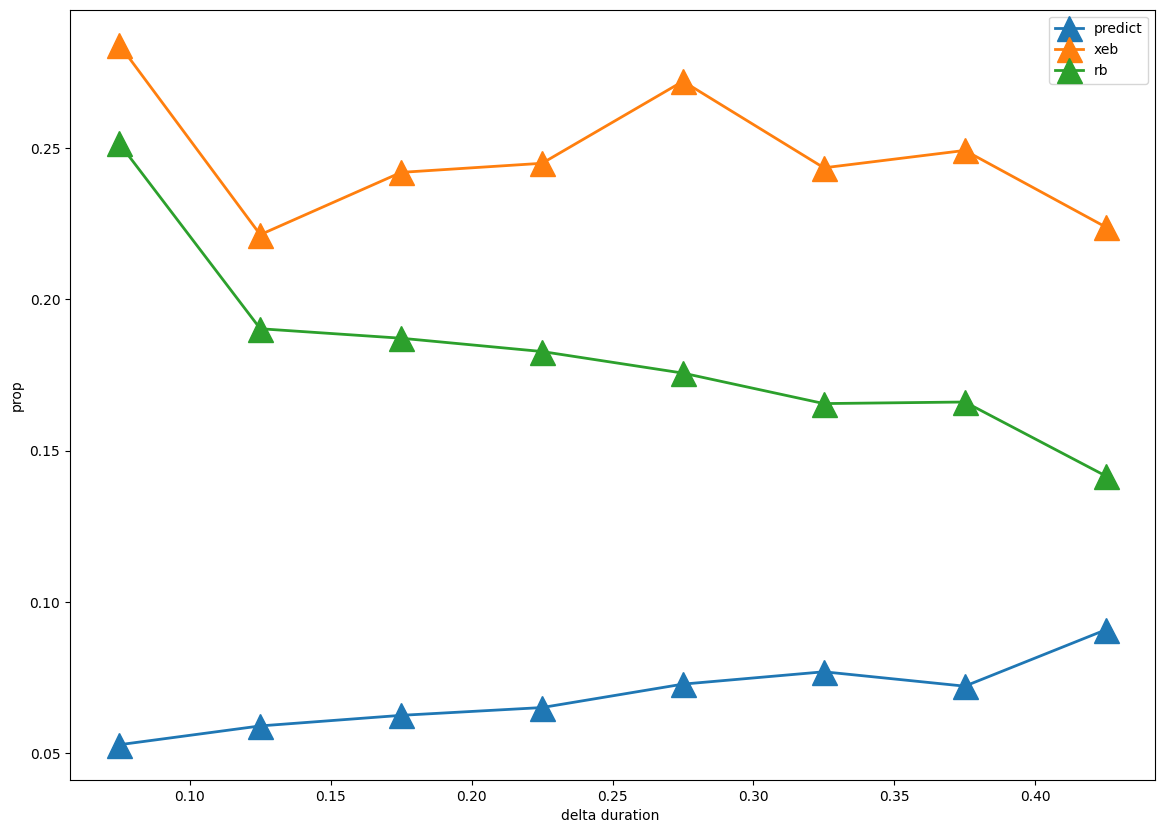

In [34]:
from plot.plot import get_prop2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
prop_X, prop2circuit_index = get_prop2circuit_infos(props,step = 0.05, max_props=0.4)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
for circuit_index in prop2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).mean())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).mean())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).mean())
    
 
axes.plot(prop_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(prop_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(prop_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('delta duration ')
axes.set_ylabel('prop')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit/step1/duration_fidelity_execute_18bit_news_train_0_2500_step1_couple.svg")  # step